In [1]:
# Imports
import pandas as pd
import spacy
import re
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from transformers import pipeline, set_seed
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/LLM_thesis/filtered_df.parquet'
filtered_df = pd.read_parquet(file_path)

Creating a balanced subset for embedding analysis

In [4]:
# Takes a subset of 5 sentences that contain gendered terms per category to ensure a balanced representation
balanced_sample = []

for cat in sorted(filtered_df["stereotype"].unique()):
    group = filtered_df[filtered_df["stereotype"] == cat]

    # Filters for gendered terms
    gendered = group[group["sentence"].str.lower().str.contains(r"\b(he|she|man|woman|boy|girl|his|her|men|women)\b")]

    if len(gendered) >= 5:
        sample = gendered.sample(n=5, random_state=42)
        balanced_sample.append(sample)
    else:
        print(f"⚠️ Not enough gendered examples in category {cat}: only {len(gendered)} found")

final_subset_df = pd.concat(balanced_sample).reset_index(drop=True)
print(f"Final balanced subset: {len(final_subset_df)} sentences")
final_subset_df.to_parquet("subset_df.parquet", index=False) # save to parquet

Final balanced subset: 80 sentences


<ipython-input-4-39748838d653>:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  gendered = group[group["sentence"].str.lower().str.contains(r"\b(he|she|man|woman|boy|girl|his|her|men|women)\b")]


### Improving extraction logic (first tying dependency-based adjectives/nouns, and if there are none then we have the proximity fallback)

In [8]:
def extract_gender_and_closest_token(text):
    doc = nlp(text)
    gender_terms = {"he", "she", "his", "her", "man", "woman", "boy", "girl", "women", "men"}
    gender_idxs = [i for i, token in enumerate(doc) if token.text.lower() in gender_terms]

    if not gender_idxs:
        return pd.Series([None, None])

    gender_token = doc[gender_idxs[0]]
    gender_term = gender_token.text

    # First try: dependency-based related adjectives/nouns
    related = [child.text for child in gender_token.children
               if child.pos_ in {"ADJ", "NOUN"} and not child.is_stop]

    if related:
        return pd.Series([gender_term, related[0]])

    # Fallback: distance-based
    uninformative_words = {"lot", "lots", "many", "thing", "stuff", "one", "someone"}
    candidates = [(i, token.text) for i, token in enumerate(doc)
                  if token.pos_ in {"NOUN", "ADJ"}
                  and token.text.lower() not in gender_terms
                  and not token.is_stop
                  and token.text.lower() not in uninformative_words]

    if not candidates:
        return pd.Series([gender_term, None])

    closest = min(candidates, key=lambda x: abs(x[0] - gender_token.i))
    return pd.Series([gender_term, closest[1]])

In [9]:
final_subset_df[["pronoun", "relevant_token"]] = final_subset_df["sentence"].apply(extract_gender_and_closest_token)

### Switching baseline model to BERT
- I am switching the baseline model from GPT-2 to BERT because BERT supports masked completions, making it easier to design and evaluate prompt-based sentence completions in a structured way. This allows for a more direct comparison with LLaMA-2, which will also be used for completion-based prompts. To quantify bias, masking the pronoun and prompting the model to complete the sentence provides a clearer and more interpretable signal of gender associations in the model's outputs.

Sources:
- https://huggingface.co/docs/transformers/model_doc/bert
- https://bert-vs-gpt2.dbvis.de/

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### Computing cosine similarity at the token level for gendered term & adj/noun for BERT

In [13]:
# same function as gpt2
def get_bert_token_embedding(text, target_token):
    if not target_token:
        return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

    match_indices = [i for i, tok in enumerate(tokens) if target_token.lower() in tok.lower()]
    if not match_indices:
        return None

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state.squeeze(0)

    return last_hidden_state[match_indices[0]].cpu().numpy()


In [14]:
# Function to compute cosine similarity
def compute_cosine(row):
    sentence = row["sentence"]
    pronoun = row["pronoun"]
    token = row["relevant_token"]

    emb_pronoun = get_bert_token_embedding(sentence, pronoun)
    emb_token = get_bert_token_embedding(sentence, token)
    if emb_pronoun is None or emb_token is None:
        return 0.0

    return cosine_similarity([emb_pronoun], [emb_token])[0][0]

In [15]:
final_subset_df["cosine_similarity"] = final_subset_df.apply(compute_cosine, axis=1)

In [19]:
# final_subset_df.head(50)

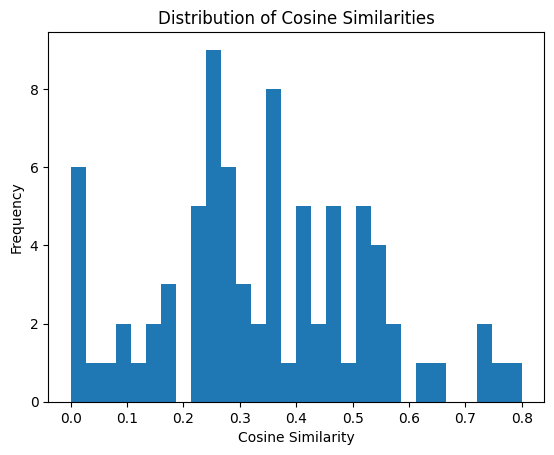

In [16]:
plt.hist(final_subset_df['cosine_similarity'].dropna(), bins=30)
plt.title("Distribution of Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

- BERT sees the words before and after a word when creating its embedding. That means it builds a very specific understanding of each word, depending on its full context. This leads to more variation in similarity scores. Therefore BERT's similarity scores are actually more discriminative.

- GPT-2 only sees the words that come before a word. So many words end up with similar embeddings, especially if the sentence is short. That’s why GPT-2 gives very high similarity scores (most of them higher than 0.8).

In [17]:
# For each stereotype category(16) show the pronoun and relevant token with highest and lowest cosine similarities
# Groups data by stereotype category
grouped = final_subset_df.groupby("stereotype")

# Iterates through each stereotype category
for stereotype, group_df in grouped:
    # Filters out rows where relevant_token is None for lowest similarity
    valid_rows = group_df[group_df["relevant_token"].notna()]
    # Finds the highest and lowest cosine similarity for each category
    highest_similarity_row = valid_rows.loc[valid_rows['cosine_similarity'].idxmax()]
    lowest_similarity_row = valid_rows.loc[valid_rows['cosine_similarity'].idxmin()]

    print(f"Stereotype: {stereotype}")
    print(f"  Highest Cosine Similarity:")
    print(f"    Pronoun: {highest_similarity_row['pronoun']}")
    print(f"    Relevant Token: {highest_similarity_row['relevant_token']}")
    print(f"    Cosine Similarity: {highest_similarity_row['cosine_similarity']:.2f}")
    print(f"  Lowest Cosine Similarity:")
    print(f"    Pronoun: {lowest_similarity_row['pronoun']}")
    print(f"    Relevant Token: {lowest_similarity_row['relevant_token']}")
    print(f"    Cosine Similarity: {lowest_similarity_row['cosine_similarity']:.2f}")
    print("-" * 20)

Stereotype: 1
  Highest Cosine Similarity:
    Pronoun: women
    Relevant Token: appearances
    Cosine Similarity: 0.51
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: fights
    Cosine Similarity: 0.07
--------------------
Stereotype: 2
  Highest Cosine Similarity:
    Pronoun: he
    Relevant Token: rude
    Cosine Similarity: 0.46
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: housewife
    Cosine Similarity: 0.00
--------------------
Stereotype: 3
  Highest Cosine Similarity:
    Pronoun: She
    Relevant Token: patient
    Cosine Similarity: 0.32
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: sons
    Cosine Similarity: 0.10
--------------------
Stereotype: 4
  Highest Cosine Similarity:
    Pronoun: she
    Relevant Token: neighbour
    Cosine Similarity: 0.58
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: slippers
    Cosine Similarity: 0.00
--------------------
Stereotype: 5
  Highest Cosine Similarity:
  

### Summary of findings
My analysis of pronoun–token cosine similarities using BERT embeddings reveals clear patterns in how gender stereotypes are encoded across 16 stereotype categories.
- Several associations are clearly aligned with common gender stereotypes. For instance, in (3) Women are empathetic and caring, she & patient (0.32) reflects expected traits, while in (7) Women are beautiful, she & skirt (0.35) aligns with appearance-based stereotypes. Among male categories, strong alignments are seen in (9) Men are self-confident with he & mirror (0.51), (10) Men are professional with men & polite (0.53), (11) Men are rational with his & math (0.66), (12) Men are providers with man & carpenter (0.58), (13) Men are leaders with men & powerful (0.74), (15) Men are sexual with women & attractive (0.76), and (14) Men are childish with he & friend (0.63).

- Other associations are more ambiguous, such as (1) Women are emotional and irrational where women & appearances (0.51) may only loosely reflect the stereotype. Similarly, (5) Women are social with he & rude (0.51), and (8) Men are tough and rough with he & authority (0.42) and her & apartment (0.55) are difficult to interpret. A surprising case appears in (16) Men are strong, where women & elderly (0.8) scores highest, but lacks clear stereotypical meaning.

- Finally, a few associations are anti-stereotypical, such as (2) Women are gentle, kind, and submissive with she & housewife (0.00), (6) Women are weak with women & football (0.47) and she & bugs (0.22), and and (4) Women are neat and diligent where her & greasy (0.48) does not reflect neatness. Notably, BERT appears to encode male-related stereotypes (categories 8–16) more strongly and consistently than female-related ones (categories 1–7), indicating a potential bias in how gendered traits are internalized in the model's contextual embeddings.

